In [40]:
import cv2
import imutils
import numpy as np
import copy
import transformations as tools
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
# Load Yolo
# loading trained network
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []  # classes are categories that we are detecting
with open("coco.names", "r") as f:  # loading classes
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

print (classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


(1200, 800, 3)


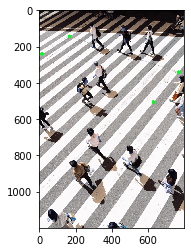

In [42]:
# Loading image
img_org = cv2.imread("test-street-01-marked.jpg")
img_org = imutils.resize(img_org, width=800)

img = copy.deepcopy(img_org)
height, width, channels = img.shape
print (img.shape)
plt.imshow(img)


In [43]:
# Detecting objects
blob = cv2.dnn.blobFromImage(
    img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)

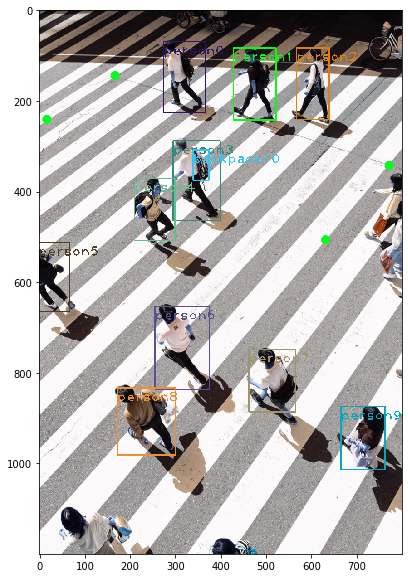

In [57]:

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
points = []


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.7 and classes[class_id] == 'person' or classes[class_id] == 'backpack':
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # lowest point of the box (on the ground)
            points.append([center_x, int(center_y+h/2)])

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
            
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label+str(i), (x, y + 30), font, 2, color, 2)

def display_img(img,cmap=None):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)

display_img(img)


[[[ 321.  226.]
  [ 475.  242.]
  [ 603.  241.]
  [ 347.  464.]
  [ 255.  508.]
  [  32.  665.]
  [ 315.  836.]
  [ 514.  886.]
  [ 237.  981.]
  [ 714. 1013.]
  [ 357.  375.]
  [ 253.  892.]]]
[[170 139]
 [ 18 238]
 [634 502]
 [775 337]]


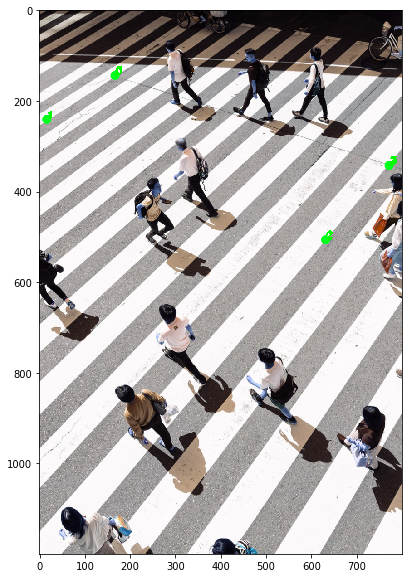

In [58]:
# finding markers

points = np.asarray(points, dtype=np.float32)
points = np.array([points])
print (points)
markers = tools.find_markers(img_org)
corners, img_org = tools.sort_markers(markers, img_org)
print (corners)
display_img(img_org)

[[ 1.27344487e+00  1.95518808e+00 -4.88256772e+02]
 [-6.50883657e-01  1.98881118e+00 -1.65794532e+02]
 [ 2.76166997e-04  1.53191886e-03  1.00000000e+00]]


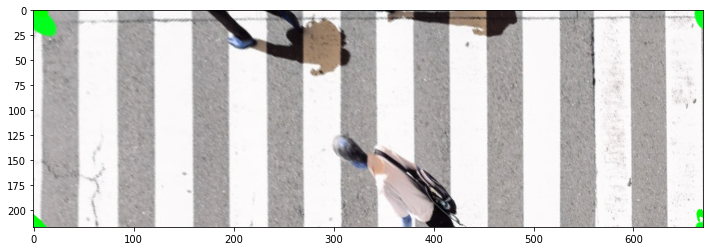

In [59]:
# perspective correction
warped, M = tools.four_point_transform(img_org, corners)
print (M)
display_img(warped)


 Homography matrix


array([[ 1.40849053e+00,  2.70429641e+00,  7.43228140e-01],
       [-4.95401638e-01,  2.85128150e+00,  3.97205468e+02],
       [ 2.76166997e-04,  1.53191886e-03,  1.00000000e+00]])

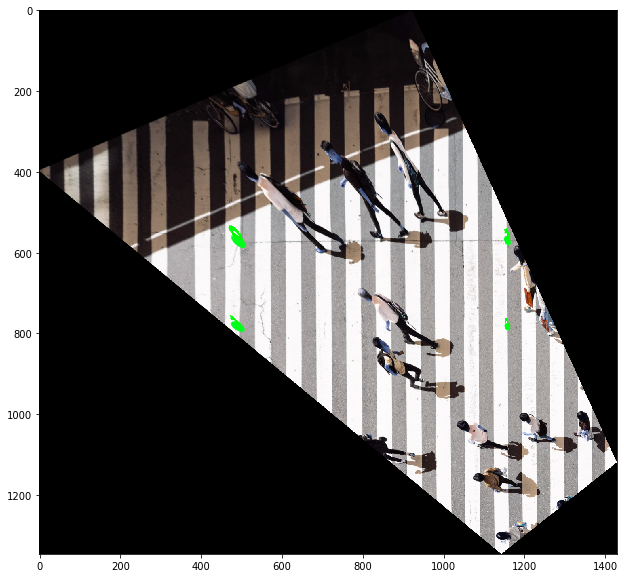

In [60]:
# padding correction
# reference: https://github.com/alkasm/padded-transformations
top_view, M = tools.warpPerspectivePadded(img_org, warped, M)
display_img(top_view)
print('\n Homography matrix')
M

[[741, 615], [881, 567], [977, 511], [965, 857], [937, 930], [909, 1123], [1142, 1108], [1248, 1067], [1163, 1198], [1362, 1066], [907, 770], [1136, 1155]]


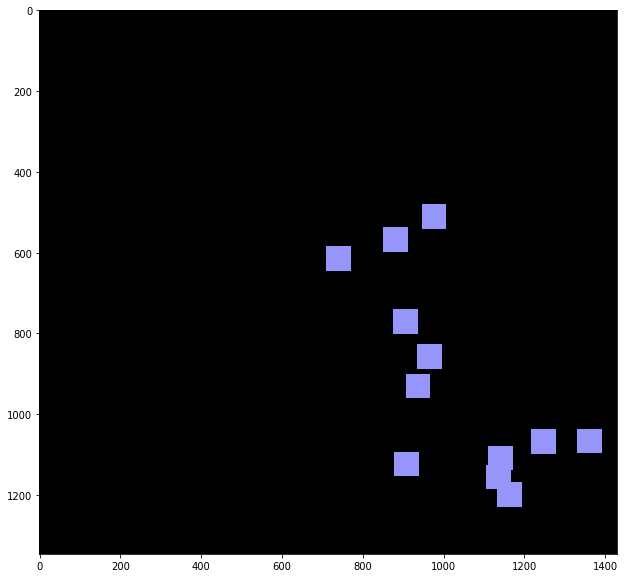

In [68]:
# Converting detected coordinates to transformed image
pointsOut = cv2.perspectiveTransform(points, M)
pointsOut = np.asarray(pointsOut, dtype=np.int32)
pointsOut = pointsOut.tolist()[0]
print (pointsOut)

# Creating blank image
height, width = top_view.shape[:2]
map = np.zeros((height, width, 3), np.uint8)
map[:, :] = (0, 0, 0)
offset = 30 
for i in pointsOut:
    cv2.rectangle(map, (i[0]-offset,i[1]-offset), (i[0]+offset,i[1]+offset), (150, 150, 250), -1)

display_img(map)

In [69]:
homography_inverse = np.linalg.inv(M)
homography_inverse


array([[ 4.67817449e-01, -5.63843078e-01,  2.23613859e+02],
       [ 1.26215188e-01,  2.93749737e-01, -1.16772809e+02],
       [-3.22547167e-04, -2.94285914e-04,  1.11713170e+00]])

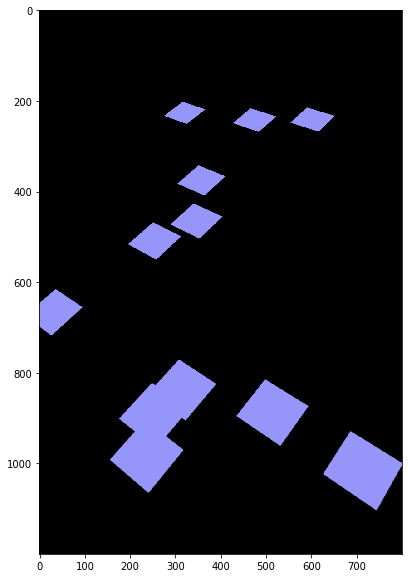

In [70]:
width, height = img.shape[:2]
map_pers = cv2.warpPerspective(map, homography_inverse, dsize = (height,width))
display_img(map_pers)

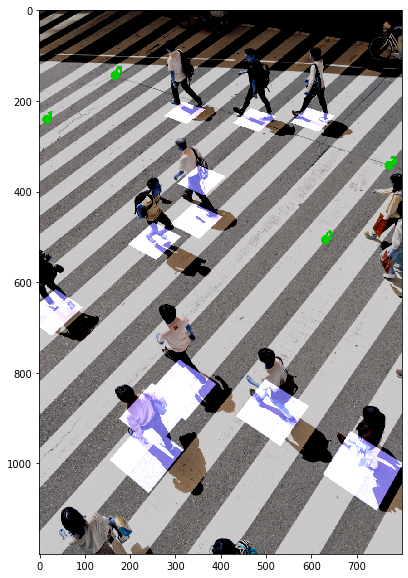

In [74]:
blended = cv2.addWeighted(src1=img_org,alpha=1,src2=map_pers,beta=1,gamma=-50)
display_img(blended)